In [1]:
import numpy as np
import pennylane as qml
import json

from susy_qm import calculate_Hamiltonian

In [8]:
file_path = r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\ADAPT-VQE\COBYLA-Test\StatevectorFilesLargerPool\AHO\data_16.txt"    

In [9]:
with open(file_path, "r", encoding="utf-8") as file:
    content = file.read()

json_part = content.split("###############################")[0].strip()
data = json.loads(json_part)

potential = data['potential']
cutoff = data['cutoff']
circuit = data["circuit"]
num_qubits = int(1+np.log2(cutoff))
basis_state = data['basis_state']

In [10]:
H = calculate_Hamiltonian(cutoff, potential)
eigenvalues, eigenvectors = np.linalg.eig(H)
min_3_ev = eigenvalues.argsort()[:4]
min_eigenvector = np.asarray(eigenvectors[:, min_3_ev[0]])

In [11]:
dev = qml.device("default.qubit", wires=num_qubits)
@qml.qnode(dev)
def create_circuit(num_qubits, basis_state, gate_list):

    qml.BasisState(basis_state, wires=range(num_qubits))

    for g in gate_list:
        gate, param, wires = g.values()
        
        if gate == "RY":
            qml.RY(param, wires=wires)

        elif gate == "CRY":
            qml.CRY(param, wires=wires)

    return qml.state()

(<Figure size 1600x600 with 1 Axes>, <Axes: >)

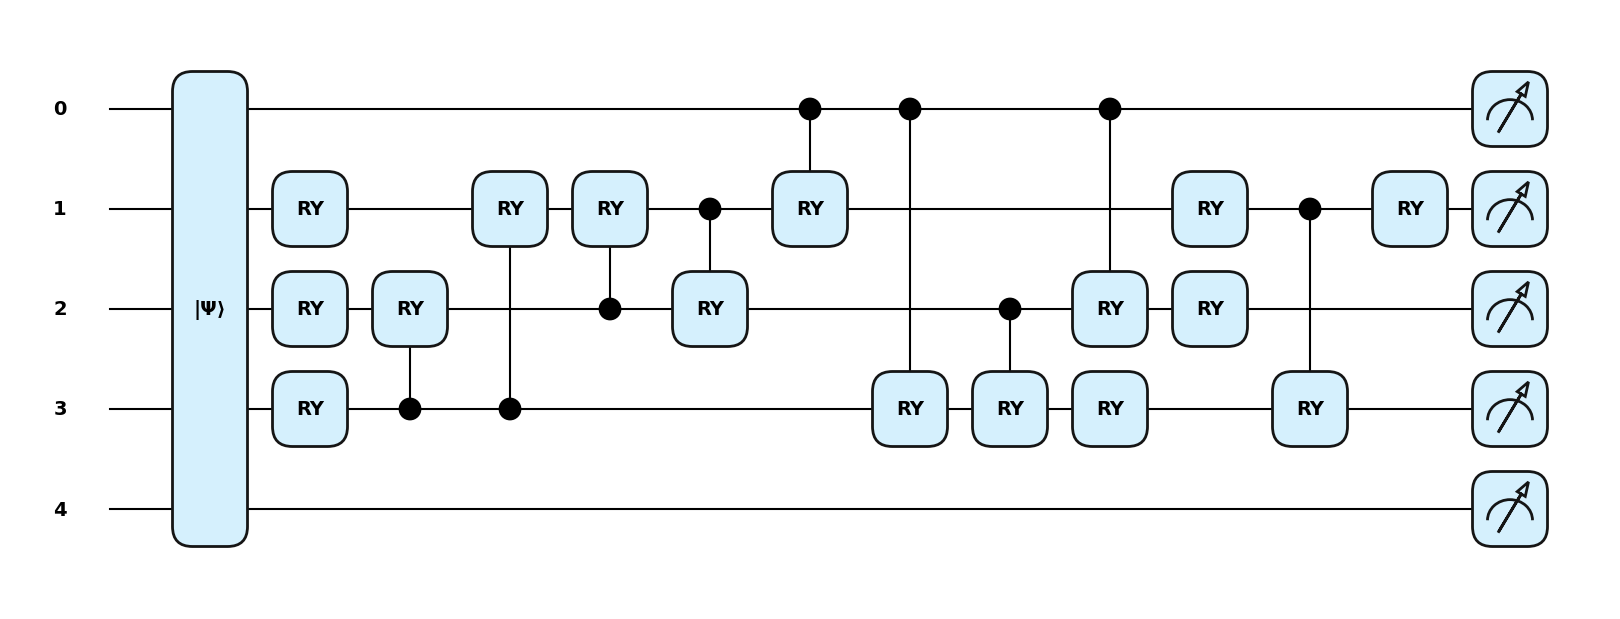

In [12]:
qml.draw_mpl(create_circuit, style='pennylane')(num_qubits, basis_state, circuit)

In [14]:
for i in range(len(circuit)):
    gate_list = circuit[:i+1]

    print(gate_list)

    psi_circuit = create_circuit(num_qubits, basis_state, gate_list)
    overlap = np.vdot(min_eigenvector, psi_circuit)
    fidelity = np.abs(overlap)**2

    #print("Overlap:", overlap)
    print("Fidelity:", fidelity)

[{'name': 'RY', 'param': 6.728462950596384, 'wires': [2]}]
Fidelity: 0.9127680164058495
[{'name': 'RY', 'param': 6.728462950596384, 'wires': [2]}, {'name': 'RY', 'param': 6.22113342893907, 'wires': [1]}]
Fidelity: 0.9139954111499439
[{'name': 'RY', 'param': 6.728462950596384, 'wires': [2]}, {'name': 'RY', 'param': 6.22113342893907, 'wires': [1]}, {'name': 'RY', 'param': 8.000474779797399, 'wires': [3]}]
Fidelity: 0.22127778538895115
[{'name': 'RY', 'param': 6.728462950596384, 'wires': [2]}, {'name': 'RY', 'param': 6.22113342893907, 'wires': [1]}, {'name': 'RY', 'param': 8.000474779797399, 'wires': [3]}, {'name': 'CRY', 'param': 8.504533627193078, 'wires': [3, 2]}]
Fidelity: 0.4115649611787495
[{'name': 'RY', 'param': 6.728462950596384, 'wires': [2]}, {'name': 'RY', 'param': 6.22113342893907, 'wires': [1]}, {'name': 'RY', 'param': 8.000474779797399, 'wires': [3]}, {'name': 'CRY', 'param': 8.504533627193078, 'wires': [3, 2]}, {'name': 'CRY', 'param': 5.256782231553179, 'wires': [3, 1]}]


In [81]:
def prune_redundant_gates(basis_state, all_gates, eigenvector, tol=1e-6):
    pruned_gates = all_gates.copy()
    best_state = create_circuit(num_qubits, basis_state, pruned_gates)
    print(best_state)
    best_fidelity = np.abs(np.vdot(eigenvector, best_state))**2
    print(best_fidelity)

    # Traverse backwards
    i = len(pruned_gates) - 1
    while i >= 0:
        trial_gates = pruned_gates[:i] + pruned_gates[i+1:]
        trial_state = create_circuit(num_qubits, basis_state, trial_gates)
        trial_fidelity = np.abs(np.vdot(eigenvector, trial_state))**2

        print(trial_fidelity)

        if trial_fidelity >= best_fidelity - tol:
            # Gate is redundant
            pruned_gates.pop(i)
            best_fidelity = trial_fidelity
        i -= 1

    return pruned_gates, best_fidelity


In [82]:
final_gates, final_fid = prune_redundant_gates(basis_state, circuit, min_eigenvector)
print("Pruned Gate List:", final_gates)
print("Final Fidelity:", final_fid)


[-0.78809286+0.j  0.58201555+0.j -0.13933049+0.j -0.08947942+0.j
  0.09466352+0.j -0.02761827+0.j -0.0315406 +0.j  0.04504699+0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
0.9999999999999878
0.9697626401985877
0.9917490385976803
0.7205128762152635
0.4153842082230733
0.09678680906903858
0.8817850171216208
0.9895135679025091
0.10206927601124213
0.6553820909423124
Pruned Gate List: [{'name': 'RY', 'param': 5.028385875511889, 'wires': [3]}, {'name': 'CRY', 'param': 6.734023688280386, 'wires': [3, 2]}, {'name': 'RY', 'param': 6.488351472871512, 'wires': [1]}, {'name': 'RY', 'param': 6.985157772439139, 'wires': [2]}, {'name': 'CRY', 'param': 6.372244357062088, 'wires': [3, 1]}, {'name': 'CRY', 'param': 5.850846941190424, 'wires': [2, 1]}, {'name': 'RY', 'param': 1.1140550292891598, 'wires': [2]}, {'name': 'CRY', 'param': 0.97805933974691, 'wires': [2, 3]}, {'name': 'CRY', 'param': 3.5342466460177278, 'wi